In [1]:
#imports
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
import dask.array as da
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
import pandas as pd
import numpy as np
import dask_ml
#prefs
pd.set_option('max_columns', None)


In [47]:
#close existing dask connection if it exists and open a new one
try:
    if client is not None:
        client.close()
        print("closed existing connection, ",client)       
except Exception as e:
    print(e)
    

closed existing connection,  <Client: not connected>


In [3]:
#get new connection
client = Client(n_workers=2, threads_per_worker=2, memory_limit='8GB')
display(client)

Client Scheduler: tcp://127.0.0.1:44219 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 12.26 GiB


In [39]:
# train on FTP-BruteForce data
data = dd.read_csv("ids-data/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv",dtype={'Active Mean': 'float64',
       'Active Std': 'float64'})



In [41]:
%%time

def time_cleaner(t):
    date, time = t.split()
    hour, minute, second = time.split(':')
    if int(hour) < 8:
        hour = int(hour) + 12
    
    return f'{date} {hour}:{minute}:{second}'

data['Timestamp'] = data['Timestamp'].apply(lambda x: time_cleaner(x), meta=('Timestamp', 'str'))
data['Timestamp'] = dd.to_datetime(data.Timestamp, format='%d/%m/%Y %H:%M:%S').astype(np.int64)

max_val = np.finfo(np.float32).max
data['Flow Byts/s'] = data['Flow Byts/s'].apply(lambda x: x if x < max_val else max_val)
data['Flow Pkts/s'] = data['Flow Pkts/s'].apply(lambda x: x if x < max_val else max_val)

clean_data = data.persist()
display(len(clean_data))


/home/mwdehn/.local/lib/python3.8/site-packages/dask/dataframe/core.py:3519: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Flow Byts/s', 'float64'))

  warnings.warn(meta_warning(meta))
/home/mwdehn/.local/lib/python3.8/site-packages/dask/dataframe/core.py:3519: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Flow Pkts/s', 'fl

1048575

CPU times: user 911 ms, sys: 146 ms, total: 1.06 s
Wall time: 12 s


In [42]:
%%time

y_test_normed = clean_data['Label'].apply(lambda x: 1 if x.lower().strip() == 'benign' else -1, meta=('Label', 'str'))

CPU times: user 31.2 ms, sys: 7.58 ms, total: 38.7 ms
Wall time: 93 ms


In [43]:
possible_features = 'Dst Port	Protocol	Timestamp	Flow Duration	Tot Fwd Pkts	Tot Bwd Pkts	TotLen Fwd Pkts	TotLen Bwd Pkts	Fwd Pkt Len Max	Fwd Pkt Len Min	Fwd Pkt Len Mean	Fwd Pkt Len Std	Bwd Pkt Len Max	Bwd Pkt Len Min	Bwd Pkt Len Mean	Bwd Pkt Len Std	Flow Byts/s	Flow Pkts/s	Flow IAT Mean	Flow IAT Std	Flow IAT Max	Flow IAT Min	Fwd IAT Tot	Fwd IAT Mean	Fwd IAT Std	Fwd IAT Max	Fwd IAT Min	Bwd IAT Tot	Bwd IAT Mean	Bwd IAT Std	Bwd IAT Max	Bwd IAT Min	Fwd PSH Flags	Bwd PSH Flags	Fwd URG Flags	Bwd URG Flags	Fwd Header Len	Bwd Header Len	Fwd Pkts/s	Bwd Pkts/s	Pkt Len Min	Pkt Len Max	Pkt Len Mean	Pkt Len Std	Pkt Len Var	FIN Flag Cnt	SYN Flag Cnt	RST Flag Cnt	PSH Flag Cnt	ACK Flag Cnt	URG Flag Cnt	CWE Flag Count	ECE Flag Cnt	Down/Up Ratio	Pkt Size Avg	Fwd Seg Size Avg	Bwd Seg Size Avg	Fwd Byts/b Avg	Fwd Pkts/b Avg	Fwd Blk Rate Avg	Bwd Byts/b Avg	Bwd Pkts/b Avg	Bwd Blk Rate Avg	Subflow Fwd Pkts	Subflow Fwd Byts	Subflow Bwd Pkts	Subflow Bwd Byts	Init Fwd Win Byts	Init Bwd Win Byts	Fwd Act Data Pkts	Fwd Seg Size Min	Active Mean	Active Std	Active Max	Active Min	Idle Mean	Idle Std	Idle Max	Idle Min'.split('\t')

exclude_features = ('Timestamp', 'Flow Byts/s', 'Flow Pkts/s')
features = [f for f in possible_features if f not in exclude_features]

features = ['Dst Port', 'Protocol', 'Flow Duration', 
                'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
                'TotLen Bwd Pkts', 'Flow Byts/s', 'Flow Pkts/s', 
                'Flow IAT Mean', 'Fwd PSH Flags', 'Bwd PSH Flags', 
                'Fwd URG Flags','Bwd URG Flags', 'FIN Flag Cnt', 
                'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 
                'ACK Flag Cnt', 'URG Flag Cnt','CWE Flag Count', 
                'ECE Flag Cnt', 'Subflow Fwd Pkts','Subflow Fwd Byts', 
                'Subflow Bwd Pkts', 'Subflow Bwd Byts']

X_train = clean_data.loc[:, features]



In [46]:
print(len([y for y in y_test_normed if y < 0]))
print(len([y for y in y_test_normed if y > 0]))

380949
667626


In [44]:
%%time

# Fit and predict based on the FTP-BruteForce attacks
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0, contamination=0.3)

clf.fit(X_train)#, y_train)
#plot_confusion_matrix(clf, X_test, y_test.apply(lambda x: -1 if x == 'Infilteration' else 1))
y_predict = clf.predict(X_train)

CPU times: user 1min 15s, sys: 17.5 s, total: 1min 32s
Wall time: 1min 30s


precision = 0.2041139441724423; recall = 0.16853174571924326; accuracy = 0.4591850845194669


314540

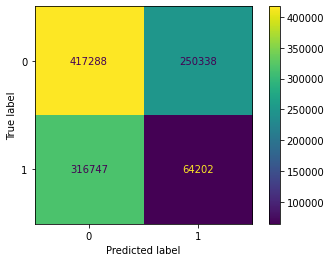

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

predicted = y_predict
actual = y_test_normed

precision = precision_score(actual, predicted, pos_label=-1)
recall = recall_score(actual, predicted, pos_label=-1)
accuracy = accuracy_score(actual, predicted)
print(f'precision = {precision}; recall = {recall}; accuracy = {accuracy}')

cm = confusion_matrix(actual, predicted, labels=[1, -1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

len([y for y in predicted if y < 0])


In [25]:
print(y_predict)
print(y_test_normed.compute())

[-1 -1 -1 ...  1  1  1]
0         1
1         1
2         1
3         1
4         1
         ..
106111    1
106112    1
106113    1
106114    1
106115    1
Name: Label, Length: 1048575, dtype: int64


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(actual, predicted)

In [ ]:
from sklearn.metrics import precision_score, recall_score

predicted = y_predict
actual = y_test_normed

precision = precision_score(actual, predicted)
recall = recall_score(actual, predicted)
print(f'precision = {precision}; recall = {recall}')

In [ ]:

def doKFolds(X,Y):
    
    #look at dask dataframes
    display(X.head())
    display(Y.head())

    #create KFold object
    c = K()
    #breakpoint()
    #split on dask arrays, doesn't work on dataframes yet
    gen = c.split(X.to_dask_array(lengths=True),Y.to_dask_array(lengths=True))

    #inspect generator
    print(gen)
    display(type(gen))
    
    #call generator
    for train,test in gen:
        print("train = ",train.compute())
        print("test = ",test.compute())
        print("x train = ",X.loc[train])
        got = X.loc[train.compute()]
        display(got.head())
        #print(got.compute())
        clf.fit(got,got)

        
doKFolds(X, Y)

In [ ]:
%%timeit -n 10
#time with just pandas
with joblib.parallel_backend('threading'):
     clf.fit(x, y)


In [ ]:
%%timeit -n 10
#time with dask
with joblib.parallel_backend('dask'):
     clf.fit(X, Y)


#clf = clf.fit(X, Y)

In [ ]:
clf.fit(X, Y)


In [ ]:
%%timeit -n 10
#time with dask, even if you set threaing it's still a dask dataframe so it's produced via dasks engine
with joblib.parallel_backend('threading'):
     clf.fit(X, Y)


#clf = clf.fit(X, Y)

In [ ]:
#cache results note you have to assign in X and Y
X = client.persist(X)
Y = client.persist(Y)

In [ ]:
%%timeit -n 10
#time with dask after cache
with joblib.parallel_backend('dask'):
     clf.fit(X, Y)

In [ ]:
%%timeit -n 10
#time with just pandas once X and Y are cached
with joblib.parallel_backend('threading'):
     clf.fit(x, y)

In [ ]:
#x = tree.plot_tree(clf,feature_names=features,class_names=labels.astype(str),rounded=True,filled=True) 
x = tree.plot_tree(clf,rounded=True,filled=True,class_names=sorted,feature_names=features) 
